In [124]:
import os
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy.stats import kendalltau

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# import brown from nltk
from nltk.corpus import brown

sns.set(context='paper', style='ticks', font_scale=1)
sns.set_palette('colorblind')

## 1. Brown corpus analysis

In [72]:
# lower case all words in the corpus
brown_words = [word.lower() for word in brown.words()]

In [93]:
# count indiivdual word frequencies and length and store in a dictionary

words_ = defaultdict(dict)

for word in brown_words:
    # if word has non-alphabetic characters, skip
    if not word.isalpha():
        continue
    if word in words_:
        words_[word]['count'] += 1
    else:
        words_[word]['count'] = 1
        words_[word]['length'] = len(word)

In [94]:
# convert to df
words_df = pd.DataFrame(words_).T
# convert count to log frequency
words_df['frequency'] = words_df['count'] / words_df['count'].sum()
words_df['log_frequency'] = np.log(words_df['frequency'])

In [95]:
# round frequency to 0 and get words with max lengths
words_df['frequency_round'] = words_df['log_frequency'].round(0)
words_df['length'] = words_df['length'].astype(int)

# get words with max length by grouping by frequency_round
words_df_max_length = words_df.groupby('frequency_round').apply(
    lambda x: x[x['length'] == x['length'].max()])

In [100]:
# get coordinates of words with max length
words_df_max_length['x'] = words_df_max_length['frequency_round']
words_df_max_length['y'] = words_df_max_length['length']
# remove duplicates by x and y
words_df_max_length = words_df_max_length.drop_duplicates(subset=['x', 'y'])

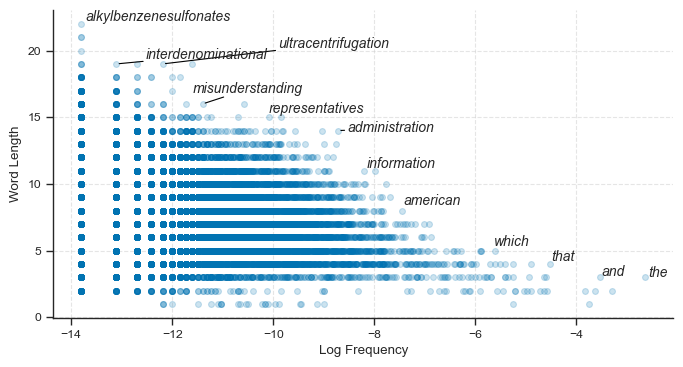

In [145]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(words_df['log_frequency'], 
            words_df['length'], 
            alpha=0.2, s=18)
# plot words with max length with labels using adjust_text
texts = []
for i, row in words_df_max_length.iterrows():
    texts.append(plt.text(row['log_frequency'], row['length'], i[1], fontsize=10, style='italic'))
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', 
                                   color='black'))
plt.ylabel('Word Length')
plt.xlabel('Log Frequency')
sns.despine()
plt.grid(alpha=0.5, linestyle='--')
plt.savefig('word_length_vs_log_frequency.png', dpi=300)
plt.show()

## 2. Theoretical limit on word length

In [129]:
word_lengths_theoretical = defaultdict(int)

for i in range(1, 25):
    word_lengths_theoretical[i] = 26 ** i

In [130]:
# get a list of all english words from nltk
from nltk.corpus import words

# get the list of english words
english_words = words.words()

In [131]:
# lower
english_words = [word.lower() for word in english_words]
# remove duplicates
english_words = list(set(english_words))
len(english_words)

234377

In [132]:
# count number of words of each length
word_lengths = defaultdict(int)

for word in english_words:
    word_lengths[len(word)] += 1

# only keep words of length 1 to 8
word_lengths = {key: value for key, value in word_lengths.items()}

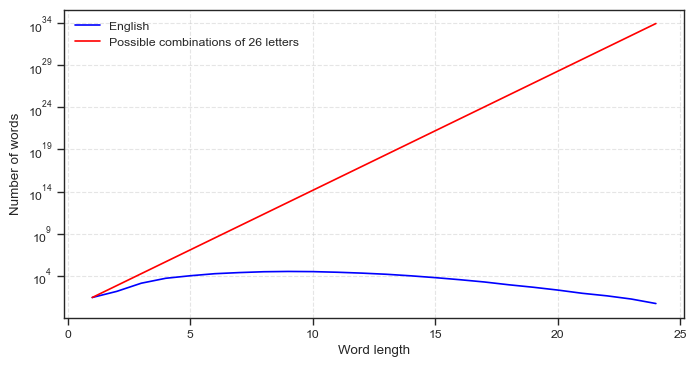

In [144]:
# plot the distribution of word lengths under 9
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(word_lengths.keys()), 
             y=list(word_lengths.values()), 
             color = 'blue', label = 'English')
# plot the theoretical distribution of word lengths under 9
sns.lineplot(x=list(word_lengths_theoretical.keys()), 
             y=list(word_lengths_theoretical.values()),
               color = 'red', 
               alpha=1,
               label = 'Possible combinations of 26 letters')
plt.xlabel('Word length')
plt.ylabel('Number of words')
plt.grid(alpha=0.5, linestyle='--')
# log scale to show 10^1
plt.yscale('log', base=10)
plt.legend(loc='upper left', frameon=False)
plt.show()

## 3. Ferrer-i-Cancho and Bentz's data

In [138]:
# read csv files from data/FreqDists_50K
path = os.path.join(cwd, 'data', 'FreqDists_50K')
files = os.listdir(path)
csv_files = [file for file in files if file.endswith('.csv')]

In [139]:
results_b = defaultdict(list)

for file in csv_files:
    data = pd.read_csv(f'data/FreqDists_50K/{file}')
    data['textfile'] = data['textfile'].astype(str)
    data['n_characters'] = [len(word) for word in data['textfile']]
    data['frequency'] = data['Freq'] / data['Freq'].sum()
    
    results_b['file'].append(file[:3])
    results_b['mean_length'].append(data['n_characters'].mean())
    # compute kendall tau for frequency and n_characters
    results_b['spearmans_rho'].append(data['frequency'].corr(data['n_characters'], method='spearman'))

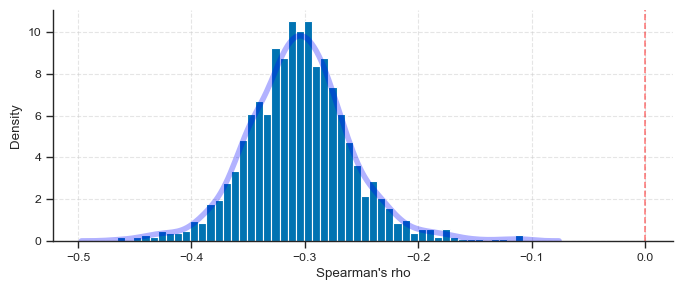

In [149]:
# plot kendall_tau distribution
plt.figure(figsize=(8, 3))
plt.hist(results_b['spearmans_rho'], bins=50, alpha=1, density=True)
sns.kdeplot(results_b['spearmans_rho'], color='blue', linewidth=4, alpha=0.3)
plt.grid(alpha=0.5, linestyle='--')
plt.axvline(0, color='red', 
            linestyle='--', 
            alpha=0.5)
plt.xlabel('Spearman\'s rho')
sns.despine()
plt.savefig('kendall_tau_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

In [142]:
# print mean, max and min for results_b['kendall_tau'] rounded to 3 decimals
print(f'Mean: {np.mean(results_b["spearmans_rho"]):.3f}')
print(f'Max: {np.max(results_b["spearmans_rho"]):.3f}')
print(f'Min: {np.min(results_b["spearmans_rho"]):.3f}')

Mean: -0.305
Max: -0.107
Min: -0.466


In [150]:
len(results_b["spearmans_rho"])

1498